In [ ]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from dataloader.dataloader import DataLoader
from preprocessing.clustering_segmentation import ClusteringSegmentation
from preprocessing.edge_detection import EdgeDetection
from preprocessing.image_restoration import ImageRestorer
from preprocessing.preproccessing import ImagePreprocessor
from preprocessing.region_segmentation import RegionBasedSegmentation
from preprocessing.threshold_segmentation import ThresholdSegmentation
from feature_extraction.feature_extraction import FeatureExtractor
from feature_selection.feature_selection import FeatureSelector
from model_selection.model_selection import ModelSelection
from performance_analysis.performance_analysis import PerformanceAnalysis
from illumination_preprocessing.illumination_preprocessing import IlluminationPreprocessing
from preprocessing.image_aligner import ImageAligner
import pickle

import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np

## Data Loading

In [ ]:
dataloader = DataLoader(Path('./data'))

# Load Data from files
x_train, y_train, x_test, y_test, x_val, y_val = dataloader.load_data(data_augmentation=False)

In [ ]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

## Preprocessing

### Illumination Processing

In [ ]:
illumination_processing = IlluminationPreprocessing()
illuminated_list = illumination_processing.process_images_loops(x_train)
illuminated_train = [t[0] for t in illuminated_list]
illuminated_train_mask = [t[1] for t in illuminated_list]

illuminated_list_val = illumination_processing.process_images_loops(x_val)
illuminated_val = [t[0] for t in illuminated_list_val]
illuminated_val_mask = [t[1] for t in illuminated_list_val]

In [ ]:
illuminated_train = np.array(illuminated_train)
illuminated_train_mask = np.array(illuminated_train_mask)
illuminated_val = np.array(illuminated_val)
illuminated_val_mask = np.array(illuminated_val_mask)

print(f"illuminated_train shape: {illuminated_train.shape}")
print(f"illuminated_train_mask shape: {illuminated_train_mask.shape}")
print(f"illuminated_val shape: {illuminated_val.shape}")
print(f"illuminated_val_mask shape: {illuminated_val_mask.shape}")

### Image Aligner

In [ ]:
image_aligner = ImageAligner()

aligned_train = image_aligner.align_image(illuminated_train)
aligned_val = image_aligner.align_image(illuminated_val)

print(f"aligned_train shape: {aligned_train.shape}")
print(f"aligned_val shape: {aligned_val.shape}")

1004


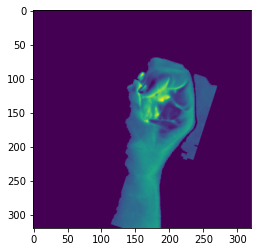

In [236]:
index = np.random.randint(0, len(aligned_train))
print(index)
plt.imshow(aligned_train[index])
plt.show()

### Edge Detection

In [ ]:
edge_detection = EdgeDetection(method="canny")
edge_detected_train = edge_detection.process(illuminated_train)
edge_detected_val = edge_detection.process(illuminated_val)

print(f"edge_detected_train shape: {edge_detected_train.shape}")
print(f"edge_detected_val shape: {edge_detected_val.shape}")

## Features Extraction And Selection

In [ ]:
feature_extractor = FeatureExtractor()
feature_selector = FeatureSelector()

pca_features_train = np.zeros((x_train.shape[0],0))
pca_features_val = np.zeros((x_val.shape[0],0))

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### Hog Features

In [ ]:
hog_features_train = feature_extractor.extract_hog_features(aligned_train)
hog_features_val = feature_extractor.extract_hog_features(aligned_val)

pca_hog_features_train = feature_selector.extract_pca_features(hog_features_train,load=False, num_pca_components=0.95)
pca_hog_features_val = feature_selector.extract_pca_features(hog_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_hog_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_hog_features_val), axis=1)

print(f"extracted_features shape: {hog_features_train.shape}")
print(f"extracted_features_val shape: {hog_features_val.shape}")

# print(f"hog pca features train shape: {pca_hog_features_train.shape}")
# print(f"hog pca features val shape: {pca_hog_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### LBP Features

In [ ]:
lbp_features_train = feature_extractor.extract_lbp_features(illuminated_train)
lbp_features_val = feature_extractor.extract_lbp_features(illuminated_val)

pca_lbp_features_train = feature_selector.extract_pca_features(lbp_features_train,load=False, num_pca_components=0.95)
pca_lbp_features_val = feature_selector.extract_pca_features(lbp_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_lbp_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_lbp_features_val), axis=1)

print(f"extracted_features shape: {lbp_features_train.shape}")
print(f"extracted_features_val shape: {lbp_features_val.shape}")

print(f"lbp pca features train shape: {pca_lbp_features_train.shape}")
print(f"lbp pca features val shape: {pca_lbp_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### SIFT Features

In [ ]:
gray_images_train = np.zeros((x_train.shape[0], x_train.shape[1], x_train.shape[2]))
gray_images_val = np.zeros((x_val.shape[0], x_val.shape[1], x_val.shape[2]))

for i in range(x_train.shape[0]):
    gray_images_train[i] = cv2.cvtColor(x_train[i], cv2.COLOR_BGR2GRAY)

for i in range(x_val.shape[0]):
    gray_images_val[i] = cv2.cvtColor(x_val[i], cv2.COLOR_BGR2GRAY)

sift_features_train = feature_extractor.extract_sift_features(illuminated_train)
sift_features_val = feature_extractor.extract_sift_features(illuminated_val)


pca_sift_features_train = feature_selector.extract_pca_features(sift_features_train,load=False, num_pca_components=0.95)
pca_sift_features_val = feature_selector.extract_pca_features(sift_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_sift_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_sift_features_val), axis=1)

print(f"extracted_features shape: {sift_features_train.shape}")
print(f"extracted_features_val shape: {sift_features_val.shape}")

print(f"sift pca features train shape: {pca_sift_features_train.shape}")
print(f"sift pca features val shape: {pca_sift_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### DAISY Features

In [ ]:
daisy_features_train = feature_extractor.extract_daisy_features(aligned_train)
daisy_features_val = feature_extractor.extract_daisy_features(aligned_val)

pca_daisy_features_train = feature_selector.extract_pca_features(daisy_features_train,load=False, num_pca_components=0.95)
pca_daisy_features_val = feature_selector.extract_pca_features(daisy_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_daisy_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_daisy_features_val), axis=1)

print(f"extracted_features shape: {daisy_features_train.shape}")
print(f"extracted_features_val shape: {daisy_features_val.shape}")

print(f"daisy pca features train shape: {pca_daisy_features_train.shape}")
print(f"daisy pca features val shape: {pca_daisy_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

In [ ]:
pickle.dump(pca_daisy_features_train, open("pca_daisy_features_train.pkl", "wb"))
pickle.dump(pca_daisy_features_val, open("pca_daisy_features_val.pkl", "wb"))

In [ ]:
pca_daisy_features_train = pickle.load(open("pca_daisy_features_train.pkl", "rb"))
pca_daisy_features_val = pickle.load(open("pca_daisy_features_val.pkl", "rb"))

pca_features_train = np.concatenate((pca_features_train, pca_daisy_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_daisy_features_val), axis=1)

print(f"daisy pca features train shape: {pca_daisy_features_train.shape}")
print(f"daisy pca features val shape: {pca_daisy_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### Fourier Descriptor Features

In [ ]:
fd_features_train = feature_extractor.extract_fourier_descriptor_features(illuminated_train)
fd_features_val = feature_extractor.extract_fourier_descriptor_features(illuminated_val)

pca_fd_features_train = feature_selector.extract_pca_features(fd_features_train,load=False, num_pca_components=0.95)
pca_fd_features_val = feature_selector.extract_pca_features(fd_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_fd_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_fd_features_val), axis=1)

print(f"extracted_features shape: {fd_features_train.shape}")
print(f"extracted_features_val shape: {fd_features_val.shape}")

print(f"fd pca features train shape: {pca_fd_features_train.shape}")
print(f"fd pca features val shape: {pca_fd_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### ORB Features

In [ ]:
orb_features_train = feature_extractor.extract_orb_features(illuminated_train)
orb_features_val = feature_extractor.extract_orb_features(illuminated_val)

pca_orb_features_train = feature_selector.extract_pca_features(orb_features_train,load=False, num_pca_components=0.95)
pca_orb_features_val = feature_selector.extract_pca_features(orb_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_orb_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_orb_features_val), axis=1)

print(f"extracted_features shape: {orb_features_train.shape}")
print(f"extracted_features_val shape: {orb_features_val.shape}")

print(f"orb pca features train shape: {pca_orb_features_train.shape}")
print(f"orb pca features val shape: {pca_orb_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### RI HOG Features

In [ ]:
ri_hog_features_train = feature_extractor.RI_HOG(illuminated_train_mask)
ri_hog_features_val = feature_extractor.RI_HOG(illuminated_val_mask)

pca_ri_hog_features_train = feature_selector.extract_pca_features(ri_hog_features_train,load=False, num_pca_components=0.95)
pca_ri_hog_features_val = feature_selector.extract_pca_features(ri_hog_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_ri_hog_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_ri_hog_features_val), axis=1)

print(f"extracted_features shape: {ri_hog_features_train.shape}")
print(f"extracted_features_val shape: {ri_hog_features_val.shape}")

print(f"ri_hog pca features train shape: {pca_ri_hog_features_train.shape}")
print(f"ri_hog pca features val shape: {pca_ri_hog_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### Hu moments Features

In [ ]:
hu_moment_features_train = feature_extractor.extract_hu_moments_features(illuminated_train_mask)
hu_moment_features_val = feature_extractor.extract_hu_moments_features(illuminated_val_mask)

pca_hu_moment_features_train = feature_selector.extract_pca_features(hu_moment_features_train,load=False, num_pca_components=0.95)
pca_hu_moment_features_val = feature_selector.extract_pca_features(hu_moment_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_hu_moment_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_hu_moment_features_val), axis=1)

print(f"extracted_features shape: {hu_moment_features_train.shape}")
print(f"extracted_features_val shape: {hu_moment_features_val.shape}")

print(f"hu_moment pca features train shape: {pca_hu_moment_features_train.shape}")
print(f"hu_moment pca features val shape: {pca_hu_moment_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### Convex Hull Features

In [ ]:
convex_hull_features_train, max_length_convex_hull = feature_extractor.extract_convex_hull_features(aligned_train)
convex_hull_features_val,_ = feature_extractor.extract_convex_hull_features(aligned_val, max_length_convex_hull)

print(f"extracted_features shape: {convex_hull_features_train.shape}")
print(f"extracted_features_val shape: {convex_hull_features_val.shape}")

pca_convex_hull_features_train = feature_selector.extract_pca_features(convex_hull_features_train,load=False, num_pca_components=0.95)
pca_convex_hull_features_val = feature_selector.extract_pca_features(convex_hull_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_convex_hull_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_convex_hull_features_val), axis=1)


print(f"convex_hull pca features train shape: {pca_convex_hull_features_train.shape}")
print(f"convex_hull pca features val shape: {pca_convex_hull_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

### Eliiptical fourier descriptors features

In [ ]:
elliptical_fd_features_train = feature_extractor.elliptical_fourier_descriptors(aligned_train)
elliptical_fd_features_val = feature_extractor.elliptical_fourier_descriptors(aligned_val)

print(f"extracted_features shape: {elliptical_fd_features_train.shape}")
print(f"extracted_features_val shape: {elliptical_fd_features_val.shape}")

pca_elliptic_fd_features_train = feature_selector.extract_pca_features(elliptical_fd_features_train,load=False, num_pca_components=0.95)
pca_elliptic_fd_features_val = feature_selector.extract_pca_features(elliptical_fd_features_val,load=True, num_pca_components=0.95)

pca_features_train = np.concatenate((pca_features_train, pca_elliptic_fd_features_train), axis=1)
pca_features_val = np.concatenate((pca_features_val, pca_elliptic_fd_features_val), axis=1)


print(f"elliptic_fd pca features train shape: {pca_elliptic_fd_features_train.shape}")
print(f"elliptic_fd pca features val shape: {pca_elliptic_fd_features_val.shape}")

print(f"pca features train shape: {pca_features_train.shape}")
print(f"pca features val shape: {pca_features_val.shape}")

## PCA

In [ ]:
# # PCA FEATURES

# pca_features_train = feature_selector.extract_pca_features(extracted_features, load=False, num_pca_components=0.85)
# pca_features_val = feature_selector.extract_pca_features(extracted_features_val, load=True, num_pca_components=0.85)

print(f"pca_features_train shape: {pca_features_train.shape}")
print(f"pca_features_val shape: {pca_features_val.shape}")

### Normalizing the PCA extracted features

In [ ]:
extracted_features_train_mean = pca_features_train.mean(axis=0)
extracted_features_train_std = pca_features_train.std(axis=0)

In [ ]:
pca_features_train = (pca_features_train - extracted_features_train_mean) /extracted_features_train_std
pca_features_val = (pca_features_val - extracted_features_train_mean) /extracted_features_train_std

extracted_features_train_mean = pca_features_train.mean(axis=0)
extracted_features_train_std = pca_features_train.std(axis=0)

## Models

In [ ]:
model_selection = ModelSelection(pca_features_train, y_train, pca_features_val, y_val)

svm, pred_train, pred_val = model_selection.SVM()
performance_analysis = PerformanceAnalysis('SVM Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('SVM VALIDATION', pred_val, y_val, True)
performance_analysis.calculate_performance_metrics()


knn, pred_train, pred_val = model_selection.KNN()
performance_analysis = PerformanceAnalysis('KNN Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('KNN VALIDATION', pred_val, y_val, True)
performance_analysis.calculate_performance_metrics()

ensemble, pred_train, pred_val = model_selection.Ensemble()
performance_analysis = PerformanceAnalysis('Ensemble Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('Ensemble VALIDATION', pred_val, y_val, True)
performance_analysis.calculate_performance_metrics()


adaboost, pred_train, pred_val = model_selection.AdaBoost()
performance_analysis = PerformanceAnalysis('AdaBoost Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('AdaBoost VALIDATION', pred_val, y_val, True)
performance_analysis.calculate_performance_metrics()

In [ ]:
ann, pred_train, pred_val = model_selection.ANN(input_dim=pca_features_train.shape[1], 
                                                output_dim=6)
performance_analysis = PerformanceAnalysis('ANN Train', pred_train, y_train)
performance_analysis.calculate_performance_metrics()
performance_analysis = PerformanceAnalysis('ANN Val', pred_val, y_val, True)
performance_analysis.calculate_performance_metrics()

## Ba3basa

In [ ]:
import cv2
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# Define CUDA kernel for reflection removal
mod = SourceModule()

# Load input image
img_path = "input.jpg"
img = cv2.imread(img_path).astype(np.float32) / 255.0

# Allocate memory on GPU
img_gpu = cuda.mem_alloc(img.nbytes)
cuda.memcpy_htod(img_gpu, img)

# Define block and grid sizes for CUDA kernel
block_size = (16, 16, 1)
grid_size = ((img.shape[0] - 1) // block_size[0] + 1, (img.shape[1] - 1) // block_size[1] + 1, 1)

# Call CUDA kernel for reflection removal
remove_reflection = mod.get_function("remove_reflection")
remove_reflection(img_gpu, np.int32(img.shape[1]), np.int32(img.shape[0]), np.int32(img.shape[2]), block=block_size, grid=grid_size)

# Copy output image from GPU to CPU
cuda.memcpy_dtoh(img, img_gpu)

# Save output image
output_path = "output.jpg"
cv2.imwrite(output_path, img * 255.0)